# Import des Data

On importe toutes les bibliothèques.

In [3]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import confusion_matrix






Importation du corpus.

In [8]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_5k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 2285


On définit les différents éléments de la *pipeline* `spacy` pour détecter les emojis et les hashtags.

In [4]:
@Language.component("hashtag")
def hashtag_pipe(
    doc : spacy.tokens.doc.Doc
) -> spacy.tokens.doc.Doc:
    """
    Spacy pipeline component that detects if a word is a hashtag or not.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input document to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed document with updated token attributes.
    """
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if token.head is not None:
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

# définition du pipe
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

# Méthodes

In [5]:
def clean_hashtag(text: str) -> str:
    """
    Remove hashtags from a text.

    Parameters
    ----------
    text : str
        The input text.

    Returns
    -------
    str
    """
    hashtag_pattern= re.compile("#[A-Za-z0-9_]+")
    return re.sub(hashtag_pattern,"", text) #On supprime tout les types de #
    

In [6]:
def clear_trailing_hash(
    corpus: pd.Series
) -> None:
    """
    Clear any trailing '#' character from each string in a list.
    
    Parameters
    ----------
    corpus : list of str
        pd.Series of strings to be processed.
    
    Returns
    -------
    None
        The function only modifies the input corpus list in place.
    """
    for i in range(len(corpus)):
        if(corpus[i][-1]=="#"):
            corpus[i] = corpus[i].rstrip(corpus[i][-1])

In [8]:
# TODO: voir si l'on peut passer en paramètre un objet spacy qui identifie le type de token,
# afin de n'écrire qu'une seule méthode (pour les hashtags, les emojis, etc...).
def top_hashtags(
    corpus: pd.Series,
    top: int = 5,
    nlp : spacy.lang.en.English
) -> pd.Series:
        """
    Retrieves the most frequent hashtags in the given corpus.
    
    Parameters
    ----------
    corpus : pd.Series
        The pd.Series of text documents to retrieve hashtags from.
    top : int, optional
        The number of top hashtags to return. Default is 5.
    nlp : spacy.lang.en.English
        A spacy language model with a custom pipe to detect hashtags.
    
    Returns
    -------
    pd.Series
        A pandas Series containing the count of each of the most frequent hashtags found in the corpus,
        sorted in descending order.
    """
    # retrieve all hashtags in corpus
    hashtags = []
    for i in corpus:
        doc = nlp(i)
        for token in doc:
            if token._.is_hashtag:
                hashtags.append(token.text)
    # count hashtags & return most frequents
    return (
        pd
        .Series(hashtags)
        .value_counts()
        .sort_values(ascending=False)
        .head(top)
    )

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 27)

In [10]:
def top_emojis(
    corpus: pd.Series,
    top: int = 5
 ) -> pd.Series:
         """
    Retrieves the most frequent emojis in the given corpus.
    
    Parameters
    ----------
    corpus : pd.Series
        The pd.Series of text documents to retrieve hashtags from.
    top : int, optional
        The number of top hashtags to return. Default is 5.
    nlp : spacy.lang.en.English
        A spacy language model with a custom pipe to detect hashtags.
    
    Returns
    -------
    pd.Series
        A pandas Series containing the count of each of the most frequent emojis found in the corpus,
        sorted in descending order.
    """
    # Retrieve emojis in corpus
    emojis = []
    for i in corpus:
        doc = nlp(i)
        for token in doc:
            if token._.is_emoji:
                emojis.append(token.text)

    # count occurrences & return most frequent
    return (
        pd
        .Series(emojis)
        .value_counts()
        .sort_values(ascending=False)
        .head(top)
    )

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 24)

In [36]:
def create_dummies(corpus: pd.Series,
                   y : pd.Series,
                   element: str,
                   top: int = 5
) -> pd.DataFrame:
    """
    Create dummy encodings for most frequents text elements in the given corpus.

    Parameters
    ----------
    corpus : pd.Series
        The corpus on which the elements will be searched for.
    y : pd.Series
        The variable which will enable to filter the rows to use to determine the top elements+
    element : str, {'hashtag', 'emoji'}
        The text element to look for. Currently, only 'hashtag' and 'emoji' are supported.
    top : int, optional
        The number of top modalities to dummy encode. Default is 5.

    Returns
    -------
    pd.DataFrame
        The dummy encoding corresponding to the most frequent modalities of the specified elements.
    
    Raises
    ------
    ValueError: if ``element`` is not supported.
    """
    def _is_hashtag(token):
        return token._.is_hashtag
    def _is_emoji(token):
        return token._.is_emoji
    if element == 'hashtag':
        detector = _is_hashtag
    elif element == 'emoji':
        detector = _is_emoji
    else:
        raise ValueError("Only 'hashtag' and 'emoji' elements are supported.")

    top_elements = (
        corpus[y==1]
        .apply(lambda text: [token.text for token in nlp(text) if detector(token)])
        .explode()
        .value_counts()
        .head(top)
        .index
    )

    dummy = pd.DataFrame(index=corpus.index)
    for e in top_elements:
        dummy[e] = corpus.apply(lambda text: 1 if e in [token.text for token in nlp(text) if detector(token)] else 0)

    return dummy

In [12]:
def get_word_ratio(
    corpus: list, 
    nlp: spacy.lang.en.English
) -> list[float]:
    """
    Computes the ratio of words to hashtags in the text column of the given dataframe.

    Parameters
    ----------
    df: pd.DataFrame
        The dataframe containing the text column.
    nlp: spacy.lang.en.English
        The spacy English pipeline.

    Returns
    -------
    List[float]
        The list of word-to-hashtag ratios computed for each text in the dataframe.
    """
    ratio = []
    for i in corpus:
        doc = nlp(i)
        nb_word = 0
        nb_hash = 0
        for token in doc:
            if(token._.is_hashtag):
                nb_hash+=1
            else:
                nb_word+=1
        if((nb_hash+nb_word)!=0):
            ratio.append(nb_word/(nb_hash+nb_word))
        else:
            ratio.append(0)  
    return ratio

In [13]:
def get_caps_ratio(
    corpus: list,
    nlp: spacy.lang.en.English
) -> list[float]:
    """
    Calculates the ratio of capitalized words in each text of the given DataFrame.
    
    Parameters
    ----------
    corpus: list
        The list containing the text to analyze.
    
    Returns
    -------
    list[float]
        The list containing the ratios of capitalized words for each text.
    """
    ratio = []
    for i in corpus:
        doc = nlp(clean_hashtag(i))
        nb_lower = 0
        nb_caps = 0
        for token in doc:
            if(token.text.isupper()):
                nb_caps+=1
            else:
                nb_lower+=1
        if((nb_caps+nb_lower)!=0):
            ratio.append(nb_caps/(nb_caps+nb_lower))
        else:
            ratio.append(1)
    return ratio

In [14]:
def get_normalized_nb_punct(
        corpus: list,
        nlp: spacy.lang.en.English
        ) -> list:
    """
    Counts the number of punctuation symbols in each string of the given corpus.
    
    Parameters
    ----------
    corpus : list
        A list of strings to be processed.
    nlp : spacy.lang.en.English
        A spaCy English language processing pipeline instance.

    Returns
    -------
    list
        A list containing the number of punctuation symbols in each string of the corpus.
    """
    tot = []
    for i in corpus:
        doc = nlp(clean_hashtag(i))
        nb_punct = 0
        for token in doc:
            if(token.is_punct):
                nb_punct+=1
        if(len(doc)!=0):
            tot.append(nb_punct/len(doc))
        else:
            tot.append(1)
    return tot

In [15]:
def del_double(
    corpus: list, 
    publication_time: list, 
    limit: float, 
    method: callable
    ) -> list: 
    """
    Remove duplicated elements from a list of strings using Levenshtein distance.

    Parameters
    ----------
    corpus : list of str
        The list of strings to remove duplicates from.
    publication_time : list of timestamp
        The list of publication time for each element in the corpus.
    limit : float
        The distance threshold under which two elements are considered duplicates.
        Must be in the range [0, 1] if using normalized Levenshtein distance, or
        in the range [0, 100] if using classical Levenshtein distance.
    method : function
        The method to use to compute the distance between two strings.

    Returns
    -------
    list of str
        The list of strings with duplicates removed.
    """
    
    t = txt.copy()
    distance = method #initialisiation de levenshtein avec la distance normalisée.
    i = 0
    r = len(t)
    while(i<r):
        r = len(t)
        j=i+1
        while(j<r):
            if(distance(clean_hashtag(t[i]).strip(),clean_hashtag(t[j]).strip()) <= s ): # Si la distance entre les deux élemens de la liste inf à seuil
                if(publication_time[i]<publication_time[j]):
                    del t[j] #delete
                    r = len(t) #on actualise la taille de la liste
                else:
                    del t[i]
                    r = len(t) #on actualise la taille de la liste
            else:
                j+=1
        i+=1
    return t

In [66]:
def train_test(
    data: pd.DataFrame,
    y: str,
    f_y0: float, 
    f_y1: float
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a pandas DataFrame into two DataFrames for training and testing purposes.

    Parameters:
    ----------
        data : pd.DataFrame
            The input DataFrame.
        y : str 
            The target variable.
        f_y0 : float
            The fraction of rows with y=0 to include in the training DataFrame.
        f_y1 : float
            The fraction of rows with y=1 to include in the training DataFrame.

    Returns:
        tuple(pd.DataFrame, pd.DataFrame): The training and testing DataFrames.
    """
    num_y0 = (data[y] == 0).sum()
    num_y1 = (data[y] == 1).sum()
    
    # Calculate the number of rows to put in train set and test set
    num_train_y0 = int(num_y0 * f_y0)
    num_train_y1 = int(num_y1 * f_y1)
    num_train = num_train_y0 + num_train_y1
    
    # Split the data into train and test sets
    train_y0 = data[data[y] == 0].sample(n=num_train_y0)
    train_y1 = data[data[y] == 1].sample(n=num_train_y1)
    train = pd.concat([train_y0, train_y1])
    test = data.drop(train.index)
    
    return train, test

# Creation d'un sample de validation

In [ ]:
import random
chanel_junk_valid = random.choices(chanel, k=700)

In [35]:
import textdistance
dist = textdistance.levenshtein.normalized_distance
chanel_junk_valid_dd = del_double(chanel_junk_valid,publication_time_chanel,0.5,dist)

NameError: name 'chanel_junk_valid' is not defined

In [ ]:
len(chanel_junk_valid_dd)

In [ ]:
chanel_junk_valid_df= pd.DataFrame()
chanel_junk_valid_df['text'] = chanel_junk_valid_dd

In [ ]:
chanel_junk_valid_df.to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid.csv")
# Ajout de la variable is_junk sur excel

### Sample de validation : 

In [40]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']]
clear_trailing_hash(chanel_junk_valid_new['text'])

C:\Users\a.tekiouk\AppData\Local\Temp\ipykernel_4092\672916536.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus[i] = corpus[i].rstrip(corpus[i][-1])


In [41]:
chanel_junk_valid_new.head()

,text,is_junk
0,The camelia - a long time symbol of Chanel and...,0
1,Wknds are my happy place 🤍 even if they do inc...,1
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1
3,My love for a chanelofficial classic flap 😌| #...,0
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1


# Ajout de features

### Ratio de mot

In [42]:
chanel_junk_valid_new['word_ratio'] = get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [30]:
chanel_junk_valid_new.head()

,text,is_junk,word_ratio
0,The camelia - a long time symbol of Chanel and...,0,0.587302
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345


### Ratio de caps

In [43]:
chanel_junk_valid_new['caps_ratio'] = get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [34]:
chanel_junk_valid_new.head()

,text,is_junk,word_ratio,caps_ratio
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455


# Nb de ponctuation

In [44]:
chanel_junk_valid_new['norm_punct'] = get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [52]:
chanel_junk_valid_new.head()

,text,is_junk,word_ratio,caps_ratio,norm_punct
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027,0.135135
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000,0.375000
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111,0.111111
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000,0.000000
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455,0.000000


### Top hashtags junk

In [ ]:
s = chanel_junk_valid_new[chanel_junk_valid_new['is_junk']==1]['text']

In [53]:
top_hashtags(s,15)

NameError: name 'top_hashtags' is not defined

### Top emojis junk

In [ ]:
top_emojis(s,15)

# Hashtag/emojis dummy

In [45]:
chanel_junk_valid_new = chanel_junk_valid_new.join(create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji', top= 5))
chanel_all_features = chanel_junk_valid_new.join(create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', top= 5))

In [46]:
chanel_all_features.head()

,text,is_junk,word_ratio,caps_ratio,norm_punct,➖,▪,🌼,✨,😍,#chanel,#fashion,#style,#ootd,#explorepage
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027,0.135135,0,0,0,0,0,1,0,0,0,0
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000,0.375000,0,0,0,0,0,1,1,1,1,0
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111,0.111111,0,0,0,0,0,0,0,0,0,0
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000,0.000000,0,0,0,0,0,1,0,0,0,0
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455,0.000000,0,0,0,0,0,0,0,0,0,0


# Correlation, boxplot

C:\Users\a.tekiouk\AppData\Local\Temp\ipykernel_4092\1709041263.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = chanel_all_features.corr(method='pearson')
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 127804 (\N{BLOSSOM}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylab

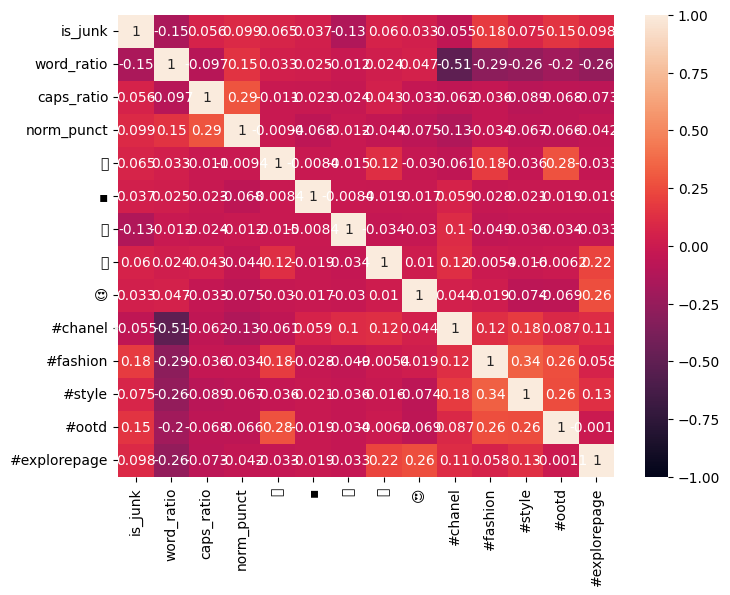

In [52]:
corr_df = chanel_all_features.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, vmin=-1, vmax=1)
plt.show()

Boxplot word ratio 

<Axes: xlabel='is_junk', ylabel='word_ratio'>

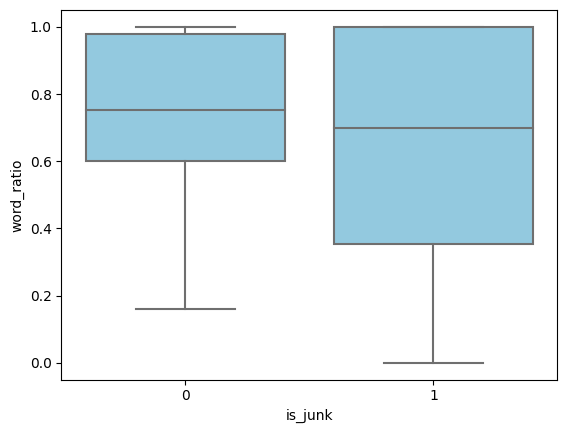

In [53]:
sns.boxplot(data  = chanel_all_features, 
            x     = "is_junk", 
            y     = "word_ratio",
            color = "skyblue")

Boxplot caps ratio

<Axes: xlabel='is_junk', ylabel='caps_ratio'>

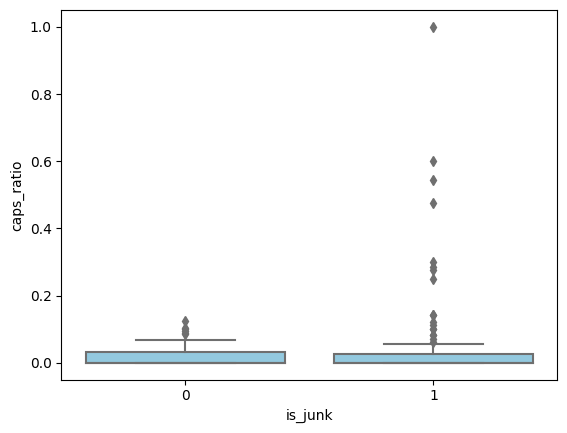

In [54]:
sns.boxplot(data  = chanel_all_features,
            x     = "is_junk",
            y     = "caps_ratio",
            color = 'skyblue')

Boxplot nb ponctuation

<Axes: xlabel='is_junk', ylabel='norm_punct'>

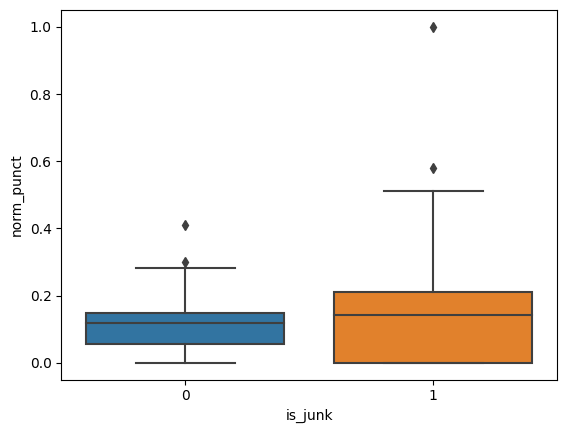

In [55]:
sns.boxplot(data = chanel_all_features,
            x    = "is_junk",
            y    = "norm_punct" )

# Arbre de decision

In [67]:
train,test = train_test(data = chanel_all_features.drop('text',axis=1), y = 'is_junk', f_y0= 0.75, f_y1= 0.40)

In [105]:
tree1 = DecisionTreeClassifier()

In [107]:
X_train = train.drop('is_junk',axis=1)
y_train = train['is_junk']
X_test = test.drop('is_junk',axis=1)
y_test = test['is_junk']

In [108]:
tree1.fit(X_train,y_train)

DecisionTreeClassifier()

[Text(0.3869047619047619, 0.9642857142857143, 'x[0] <= 0.389\ngini = 0.453\nsamples = 98\nvalue = [34, 64]'),
 Text(0.19047619047619047, 0.8928571428571429, 'x[0] <= 0.222\ngini = 0.091\nsamples = 21\nvalue = [1, 20]'),
 Text(0.14285714285714285, 0.8214285714285714, 'x[0] <= 0.171\ngini = 0.18\nsamples = 10\nvalue = [1, 9]'),
 Text(0.09523809523809523, 0.75, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(0.19047619047619047, 0.75, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.23809523809523808, 0.8214285714285714, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]'),
 Text(0.5833333333333334, 0.8928571428571429, 'x[2] <= 0.139\ngini = 0.49\nsamples = 77\nvalue = [33, 44]'),
 Text(0.38095238095238093, 0.8214285714285714, 'x[9] <= 0.5\ngini = 0.47\nsamples = 37\nvalue = [23, 14]'),
 Text(0.2857142857142857, 0.75, 'x[6] <= 0.5\ngini = 0.43\nsamples = 32\nvalue = [22, 10]'),
 Text(0.23809523809523808, 0.6785714285714286, 'x[1] <= 0.021\ngini = 0.391\nsamples = 30\nvalue = [22, 8]'),
 Text

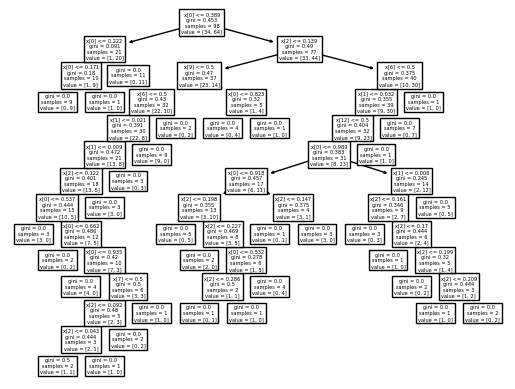

In [128]:
sklearn.tree.plot_tree(tree1)

In [123]:
pred = tree1.predict(X_test)

In [124]:
cm = confusion_matrix(y_true = y_test, y_pred = pred)

print(f"TP : {cm[0,0]}  | FP : {cm[0,1]}\nFN : {cm[1,0]} | TN : {cm[1,1]}")

TP : 8  | FP : 4
FN : 27 | TN : 70
